# Project 1 Code

### Installing the Required Libraries
The experiment was run in an HPC, so at first all the required libraries were installed

In [1]:
!pip install torch
!pip install torchvision
!pip install torchinfo
!pip install pandas
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Model Definition

The model created is a modified ResNet18 Model.

The model definition code is based on the code from this [repository](https://github.com/kuangliu/pytorch-cifar/tree/master/models)

In [ ]:
# Adding the imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

In [ ]:
# Model Definition

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3,
            stride=stride, padding=1, bias=False,
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block: BasicBlock, num_blocks: list[int], num_classes: int=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3,
            stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 255, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 244, num_blocks[3], stride=2)
        self.linear = nn.Linear(244*block.expansion, num_classes)

    def _make_layer(
            self,
            block: BasicBlock,
            planes: int,
            num_blocks: int,
            stride: int
        ) -> nn.Sequential:
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CustomResNet() -> None:
    return ResNet(BasicBlock, [2, 2, 2, 2])

## Summary of the model

In [4]:
from torchinfo import summary

model = CustomResNet()
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Sequential: 3-5              --
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─Conv2d: 3-8                  36,864
│    │    └─BatchNorm2d: 3-9             128
│    │    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728
│    │    └─BatchNorm2d: 3-12            256
│    │    └─Conv2d: 3-13                 1

From above, we can see that our model satisfies the constraint of the competition of having parameters less than 5 million.

## Utility function
Show custom progress bar during training process

In [ ]:
import os
import sys
import time

TOTAL_BAR_LENGTH = 65
last_time = time.time()
begin_time = last_time

term_width = 15

def progress_bar(current: int, total: int, msg: str) -> None:
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds: int) -> str:
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

## Data Augmentation

We used data augmentation techniques to diversify our training dataset, leading to a more generalized model

In [ ]:
transform_train = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    # transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Getting the Train and Validation Dataset using torchvision
# Using Torchvision as a simplified API to access the same dataset as in the competition
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=4)

# Keeping Track of the accuracies (for plotting)
train_acc = []
test_acc = []


## Model and Hyper-parameters Initialization

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
net = CustomResNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


# Hyper-parameter of the model
LR = 0.09
W_D = 1e-4
T_EPOCH = 1000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(),
    lr=LR,
    momentum=0.9,
    weight_decay=W_D
)

# Check if there is checkpoint or not
# Loads the checkpoint state if checkpoint exists
if os.path.isdir('checkpoint'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    checkpoint_dict = checkpoint['net']
    net.load_state_dict(checkpoint_dict)
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_EPOCH)

## Model Training

In [ ]:
# Training the model

def train_step(epoch: int) -> None:
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(
            batch_idx,
            len(trainloader), 
            f'Loss: {(train_loss/(batch_idx+1)):.3f} | Acc: {(100.*correct/total):.3f} ({correct}/{total})'
            )
    train_acc.append(100. * correct/total)


def test_step(epoch: int) -> None:
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(
                batch_idx,
                len(testloader),
                f'Loss: {(test_loss/(batch_idx+1)):.3f} | Acc: {(100.*correct/total):.3f} ({correct}/{total})'
            )

    # Save checkpoint if test accuracy is higher than above
    acc = 100.*correct/total
    test_acc.append(acc)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+T_EPOCH):
    train_step(epoch)
    test_step(epoch)
    scheduler.step()


Epoch: 381
 [================================================================>]  Step: 69ms | Tot: 11s608ms | Loss: 0.188 | Acc: 93.642% (46821/50000) 98/98  ================>...............................................]  Step: 101ms | Tot: 3s219ms | Loss: 0.075 | Acc: 97.512% (13480/13824) 27/98 
 [===============================================================>.]  Step: 6ms | Tot: 923ms | Loss: 0.539 | Acc: 85.640% (8564/10000) 40/40 

Epoch: 382
 [================================================================>]  Step: 68ms | Tot: 11s896ms | Loss: 0.237 | Acc: 91.850% (45925/50000) 98/98  
 [===============================================================>.]  Step: 5ms | Tot: 823ms | Loss: 0.317 | Acc: 90.780% (9078/10000) 40/40 

Epoch: 383
 [================================================================>]  Step: 67ms | Tot: 11s818ms | Loss: 0.213 | Acc: 92.616% (46308/50000) 98/98  ============================================>...................]  Step: 101ms | Tot: 8s538ms 

### Plotting the Training and Testing Accuracies

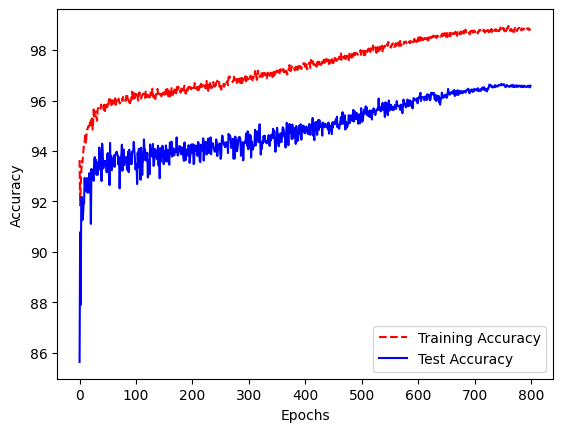

In [16]:
# Plot out the training and testing accuracy
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(len(train_acc))
tr_acc_plt = np.array(train_acc)
ts_acc_plt = np.array(test_acc)
plt.plot(n, tr_acc_plt, 'r--', label="Training Accuracy")
plt.plot(n, ts_acc_plt, 'b', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

## Predicting the test data (from the competition)

In [ ]:
# Predict the kaggle test dataset

import pickle
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

#  Custom Dataset for Kaggle's Test Pickle Files
class CustomTestDataset(Dataset):
    def __init__(self, file_path: str, transform: transforms.Compose =None):
        self.transform = transform
        self.data, self.image_ids = self.load_data(file_path)

    def load_data(self, file_path: str) -> tuple[np.ndarray, list[int]]:
        # Open the .pkl file
        with open(file_path, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')

        # Extract the image data
        data = batch[b'data']  # Shape: (N, 32, 32, 3)
        image_ids = batch[b'ids']  # Extract provided image IDs

        # Convert shape from (N, 32, 32, 3) → (N, 3, 32, 32)
        # Doing this to comply with model's input
        data = np.transpose(data, (0, 3, 1, 2)).astype(np.float32) / 255.0

        return data, image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image = torch.tensor(self.data[idx])
        image_id = self.image_ids[idx]  # Use provided ID from dataset

        if self.transform:
            image = self.transform(image)

        return image, image_id

# Define Test Transformations
# Same as test transformation above
kaggle_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the Pickle Test Dataset
test_dataset_path = "./cifar_test_nolabel.pkl"  # Updated file path
kaggle_data = CustomTestDataset(test_dataset_path, transform=kaggle_transform)
kaggle_loader = DataLoader(kaggle_data, batch_size=256, shuffle=False, num_workers=4)

# Load the Trained Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomResNet()  # Replace with your trained model
checkpoint_path = "./checkpoint/ckpt.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['net']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}  # Remove 'module.' prefix if present
    model.load_state_dict(new_state_dict)
    print(f"✅ Model loaded successfully! Best Accuracy: {checkpoint['acc']}% at Epoch {checkpoint['epoch']}")
else:
    raise FileNotFoundError("❌ Checkpoint file not found! Ensure the model was trained and saved correctly.")  # Load trained weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Make Predictions
predictions = []

with torch.no_grad():
    for images, image_ids in kaggle_loader:
        images = images.to(device)

        # Forward pass through the model
        outputs = model(images)

        # Get predicted class labels
        _, predicted = torch.max(outputs, 1)

        # Append results (ID, Prediction)
        for img_id, pred in zip(image_ids.numpy(), predicted.cpu().numpy()):
            predictions.append((img_id, pred))

# Save Predictions to CSV
df = pd.DataFrame(predictions, columns=["ID", "Labels"])
df.to_csv("cifar10_predictions.csv", index=False)

print("✅ Predictions saved successfully to cifar10_predictions.csv")

✅ Model loaded successfully! Best Accuracy: 96.66% at Epoch 1128
✅ Predictions saved successfully to cifar10_predictions.csv
